In [1]:
from urllib.parse import urlparse
import boto3
from io import BytesIO


class S3Url(object):
    """
    >>> s = S3Url("s3://bucket/hello/world")
    >>> s.bucket
    'bucket'
    >>> s.key
    'hello/world'
    >>> s.url
    's3://bucket/hello/world'

    >>> s = S3Url("s3://bucket/hello/world?qwe1=3#ddd")
    >>> s.bucket
    'bucket'
    >>> s.key
    'hello/world?qwe1=3#ddd'
    >>> s.url
    's3://bucket/hello/world?qwe1=3#ddd'

    >>> s = S3Url("s3://bucket/hello/world#foo?bar=2")
    >>> s.key
    'hello/world#foo?bar=2'
    >>> s.url
    's3://bucket/hello/world#foo?bar=2'
    """

    def __init__(self, url):
        self._parsed = urlparse(url, allow_fragments=False)

    @property
    def bucket(self):
        return self._parsed.netloc

    @property
    def key(self):
        if self._parsed.query:
            return self._parsed.path.lstrip('/') + '?' + self._parsed.query
        else:
            return self._parsed.path.lstrip('/')

    @property
    def url(self):
        return self._parsed.geturl()

session = boto3.Session(profile_name='default')
client = session.client("s3", region_name="us-east-1")

def image_from_s3(url):
    s3_url = S3Url(url)
    resp = client.get_object(Bucket=s3_url.bucket, Key=s3_url.key)
    raw = resp.get('Body').read()
    return Image.open(BytesIO(raw))


In [2]:
import torchvision
import os


class S3Coco(torchvision.datasets.CocoDetection):
    def __init__(self, ann_file):
        super(S3Coco, self).__init__("", ann_file)
        self.processor = processor

    def _load_image(self, id):
        path = self.coco.loadImgs(id)[0]["file_name"]
        # return Image.open(os.path.join(self.root, path)).convert("RGB")
        return image_from_s3(path).convert("RGB")

In [78]:
import json
import os
from urllib.parse import urlparse
from utils.split import split_image_with_labels

coco_image = {
	"width": int,
	"height": int,
	"id": int,
	"file_name": str
}
coco_annotation = {
	"image_id": int,
	"bbox": list[float],
	"category_id": int,
	"segmentation": list[float],
	"area": float,
	"iscrowd": int,
	"id": int
}
large_coco = json.load(open('datasets/result.json'))
coco_images: list[coco_image] = large_coco['images']
image_id_seq = 0
annotation_id_seq = 0
small_images: list[coco_image] = []
small_annotations: list[coco_annotation] = []


for coco_img in coco_images:
	annotations: list[coco_annotation] = list(filter(lambda ann: ann["image_id"] == coco_img["id"], large_coco['annotations']))
	if len(annotations) == 0:
		continue
	image = image_from_s3(coco_img['file_name'])
	split_images = split_image_with_labels(image=image, labels=annotations, 
															  hint_size_min=(800,800), hint_size_max=(1333,1333), 
															  overlap=0.1)
	for small in split_images:
		image_id_seq += 1
		image_id = image_id_seq
		left, top, _, _ = small["area"]
		url = urlparse(coco_img['file_name'], allow_fragments=False)
		file_name = url.path.split('/')[-1]
		file_name, file_extension = os.path.splitext(file_name)
		file_name = f"{file_name}_({left},{top}){file_extension}"
		if small['labels'] == []:
			continue
		small["image"].save(f"datasets/small/{file_name}")
		small_images.append({
			"width": small["image"].width,
			"height": small["image"].height,
			"id": image_id,
			"file_name": f"datasets/small/{file_name}"
		})
		for ann in small["labels"]:
			annotation_id_seq += 1
			small_annotations.append({
				"image_id": image_id,
				"bbox": ann["bbox"],
				"category_id": ann["category_id"],
				"segmentation": ann["segmentation"],
				"area": ann["bbox"][2] * ann["bbox"][3],
				"iscrowd": ann["iscrowd"],
				"id": annotation_id_seq
			})

large_coco['images'] = small_images
large_coco['annotations'] = small_annotations
json.dump(large_coco, open('datasets/small.json', 'w'))

In [271]:
import torchvision
import os


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"] # remove batch dimension

        return pixel_values, target

In [272]:
from transformers import DetrImageProcessor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
import torch

coco = CocoDetection(img_folder='.', ann_file='datasets/small.json', processor=processor)
train_ratio = 0.8
train_size = int(train_ratio * len(coco))
val_size = len(coco) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(coco, [train_size, val_size])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [273]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 1196
Number of validation examples: 300


Image n°2124


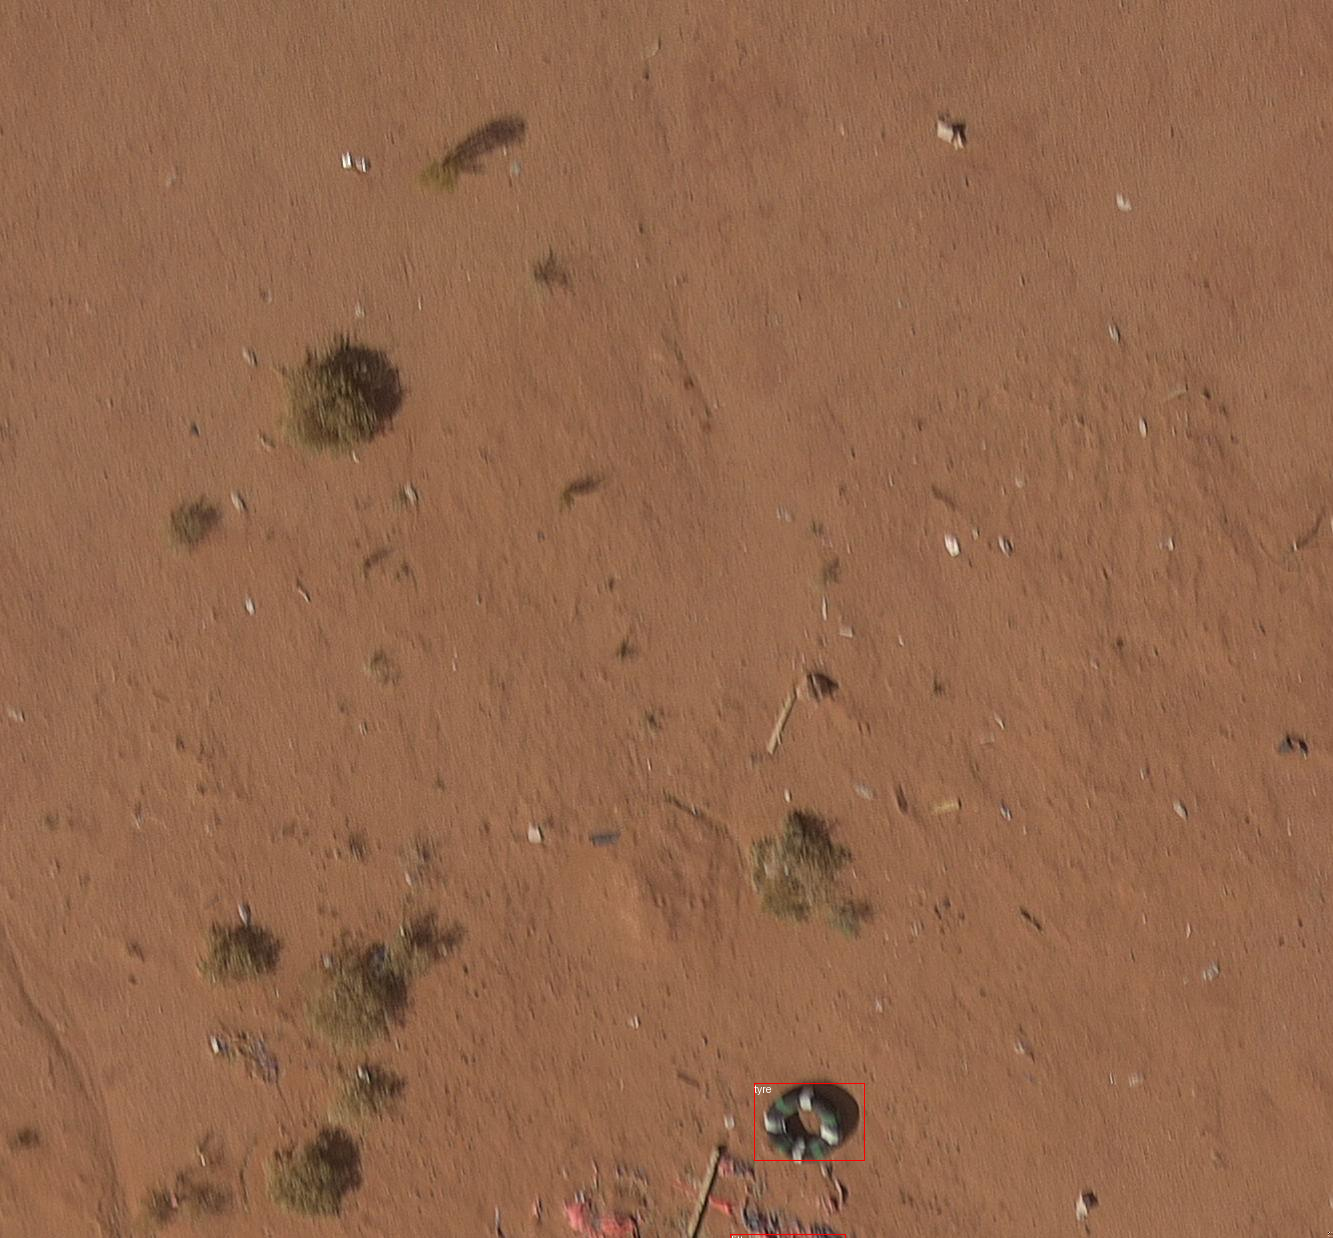

In [274]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = coco.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = coco.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))

annotations = coco.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = coco.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [275]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [276]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [277]:
pixel_values, target = train_dataset[0]

In [278]:
pixel_values.shape

torch.Size([3, 800, 861])

In [279]:
print(target)

[{'size': tensor([800, 861]), 'image_id': tensor([51]), 'class_labels': tensor([15, 10]), 'boxes': tensor([[0.3256, 0.2081, 0.0664, 0.0704],
        [0.0783, 0.1302, 0.1566, 0.2604]]), 'area': tensor([ 3221.6738, 28087.2852]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([1238, 1333])}]


In [280]:
from lightning.pytorch import LightningModule
from transformers import DetrForObjectDetection
import torch

class Detr(LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for ts in batch["labels"] for t in ts]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [189]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 69958), started 19:46:25 ago. (Use '!kill 69958' to kill it.)

In [284]:
model = Detr(lr=1e-5, lr_backbone=1e-6, weight_decay=1e-5)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [285]:
outputs.logits.shape

torch.Size([4, 100, 17])

In [286]:
from lightning.pytorch import Trainer

trainer = Trainer(max_steps=6000, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.1 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.022   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [289]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

repo_name = "mingyang91/detr-finetuned-all-in-one"

model.model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)


model = DetrForObjectDetection.from_pretrained(repo_name, id2label=id2label)
device = torch.device("mps") # torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained(repo_name)

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [301]:
from train import Detr
model = Detr.load_from_checkpoint("lightning_logs/version_32/checkpoints/epoch=461-step=6000.ckpt")
device = torch.device("mps") # torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

In [310]:
model.to(device)
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[33]

In [311]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 861])


In [312]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [313]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [314]:
target

[{'size': tensor([800, 861]), 'image_id': tensor([174]), 'class_labels': tensor([10, 10, 10, 10, 10, 10]), 'boxes': tensor([[0.0172, 0.2906, 0.0251, 0.0188],
         [0.2446, 0.2648, 0.0343, 0.0303],
         [0.2939, 0.4121, 0.0185, 0.0196],
         [0.4223, 0.4447, 0.0093, 0.0334],
         [0.0355, 0.5686, 0.0096, 0.0144],
         [0.3498, 0.5417, 0.0108, 0.0069]]), 'area': tensor([324.5233, 715.4871, 250.3553, 214.8290,  95.0036,  51.3292]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([1238, 1333])}]

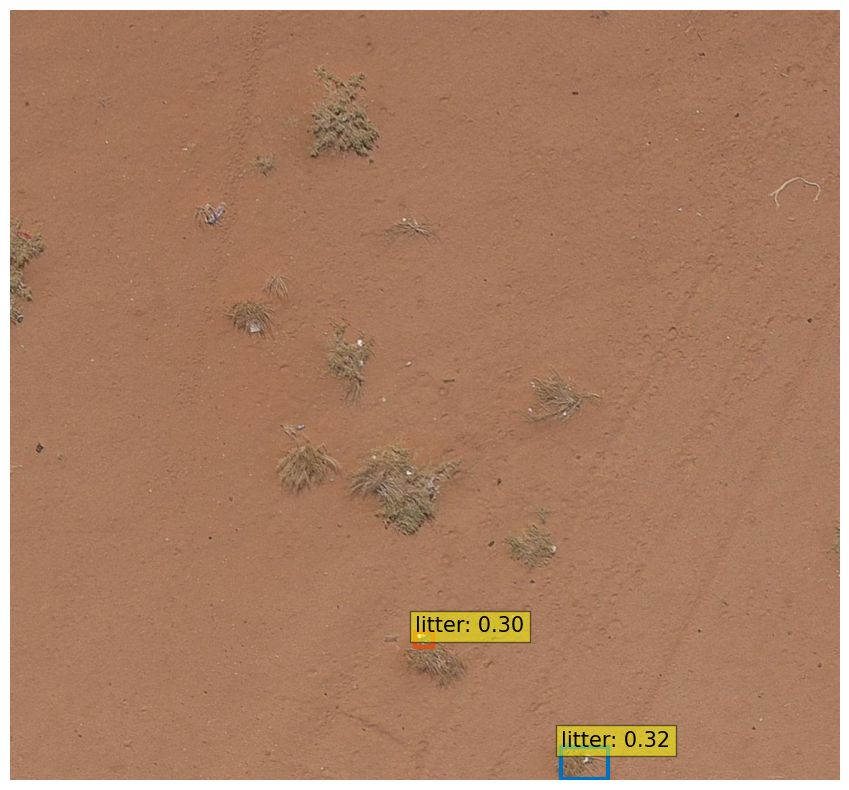

In [317]:
# load image based on ID
image_id = target[0]['image_id'].item()
image = coco.coco.loadImgs(image_id)[0]
image = Image.open(image['file_name'])

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.3)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [308]:
all_labels = set()
max_score = 0


def check(index: int) -> bool:
	global max_score
	pixel_values, target = val_dataset[index]
	pixel_values = pixel_values.unsqueeze(0).to(device)
	with torch.no_grad():
  	# forward pass to get class logits and bounding boxes
		outputs = model(pixel_values=pixel_values, pixel_mask=None)
	# load image based on ID
	image_id = target[0]['image_id'].item()
	image = coco.coco.loadImgs(image_id)[0]
	image = Image.open(image['file_name'])
	gt_labels = coco.coco.loadAnns(image_id)

	# postprocess model outputs
	width, height = image.size
	postprocessed_outputs = processor.post_process_object_detection(outputs,
																																	target_sizes=[(height, width)],
																																	threshold=0.1)
	results = postprocessed_outputs[0]
	all_labels.update(results["labels"].tolist())
	max_score = max(max_score, results["scores"].max())
	# return plot_results(image, results['scores'], results['labels'], results['boxes'])


for i in range(len(val_dataset)):
	check(i)

print(all_labels, max_score)

{0, 2, 10, 3} tensor(0.4449, device='mps:0')


In [178]:
all_cats = list(map(lambda ann: ann['category_id'], coco.coco.anns.values()))
for i in range(len(coco.coco.cats)):
	print(f"{i}: {all_cats.count(i)}")

0: 1005
1: 0
2: 582
3: 661
4: 6
5: 43
6: 0
7: 14
8: 237
9: 77
10: 2171
11: 191
12: 0
13: 312
14: 2
15: 10
